# Authors: Dan Ramachandran, Loki Aguilera-Keifert
# **Final**


## Introduction

### Dataset

* Link: https://data.iowa.gov/Property-Assessment-Levy/Levy-Authority-Rates-in-Iowa-by-Fiscal-Year/xmkr-kpjb/about_data
* Description: "This dataset contains property tax rates for all levy authorities within the State of Iowa by fiscal year. Property tax rates are the dollars collected per $1,000 in a property's taxable value. The state fiscal year runs from July 1 to the following June 30 and is numbered for the calendar year in which it ends. Rates for a fiscal year are based on the taxable property valuations for the preceding calendar year (e.g. FY 2014 rates are based on 2012 taxable property valuations)."


#### Data Coverage

Beginning: 2001-07
Last Updated: 2024-07-17

#### Overview of Columns (15)

| Column Name          | Description                                                                 | Data Type |
|----------------------|---------------------------------------------------------------------------|-----------|
| `unique_line_id`     | An identifier to denote unique lines of data.                            | Text      |
| `co_subdivision_fip` | A ten-digit Federal Information Processing Series code for county subdivisions. | Text      |
| `urban_rate`        | Rate applied to property considered urban.                                | Number    |
| `rural_rate`        | Rate applied to property considered rural.                                | Number    |
| `debt_rate`         | Rate applied to the levy authority's debt.                               | Number    |
| `tif_rate_urban`    | TIF Rate applied to urban properties.                                    | Number    |
| `tif_rate_rural`    | TIF Rate applied to rural properties.                                    | Number    |
| `fiscal_year`       | The state fiscal year (July 1 to June 30, named after ending year).     | Number    |
| `type`             | Category of levy authorities.                                           | Text      |
| `levy_authority_1`  | Unique ID for the levy authority.                                      | Text      |
| `levy_authority_2`  | Name of the levy authority.                                           | Text      |
| `county_fip`        | A five-digit Federal Information Processing Series code for counties.  | Text      |
| `county_name`       | Name of the county the levy authority is located in.                   | Text      |
| `city_fips`        | A seven-digit Federal Information Processing Series code for cities.   | Text      |
| `city_name`        | Name of the city where the levy authority is located (if applicable). | Text      |


### Target Audience

Homeowners and potential homebuyers would see great value in seeing how property taxes affected particular counties YoY. Some questions they may have may deal with how property taxes have fluctuated over the past X amount of years, how property taxes for certain townships and cities vary (as it relates to property value) as well as for other commercial properties in the area (which could end up being passed along as a consumer tax  

### Background on Iowa Counties and Levy Authorities

*How many counties are there in Iowa?*

There are **99** counties in Iowa according to https://www.census.gov/geographies/reference-files/2010/geo/state-local-geo-guides-2010/iowa.html

*What is a levy rate?*

There are a number of different taxing districts in a jurisdiction, each with a different levy rate. Each year the county auditor determines for that district a levy rate that will yield enough money to fund the different entities in that district. The entities include local schools, counties, cities, townships, community colleges, local assessors, and others. Since more than one taxing authority is calculating a tax rate for the property, all the rates are added together, resulting in a single tax levy called a consolidated levy. This consolidated levy is always the result of two or more tax rates established by different government entities. - https://storycountyiowa.gov/FAQ.aspx?QID=267

*What is a levy authority?*

"A Levy Authority is a governmental entity with statutory authority to levy property taxes. These entities include counties, cities, school districts, townships, community colleges, local assessors, and others." - https://claycounty.iowa.gov/faqs/


*What are the different levy authorities in Iowa?*


- **K-12 Schools** – Public school districts levying taxes for education.
- **Counties** – County governments funding local services.
- **Cities** – Municipal governments levying taxes for city infrastructure and services.
- **Community Colleges** – Area community colleges levying taxes for post-secondary education.
- **County Hospitals** – Public hospitals with taxing authority for healthcare services.
- **Assessors** – Offices responsible for property valuation.
- **Townships** – Local township governments providing rural services.
- **Agricultural Extension (Ag Extension)** – Entities funding agricultural and community education.
- **Sanitary Sewer** – Districts levying taxes for water treatment and waste management.
- **Miscellaneous** – Other special-purpose entities with taxing authority.
- **State** – The state government’s role in property tax allocation.

[Property Taxes by Type of Taxing Authority](https://drive.google.com/uc?export=download&id=1890bRVFWS22E4kSPdw2xbUkfQ0_qBzpb)



### Environment Setup

In [2]:
import requests
import json
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# Define the API URL
API_URL = "https://data.iowa.gov/resource/xmkr-kpjb.json"

# Fetch all data in chunks using pagination
data_list = []
offset = 0
limit = 50000  # Adjust if needed


# While loop to request relevant data, append the data to a list, and then keep looping through available data until no more.

while True:
    response = requests.get(API_URL, params={"$limit": limit, "$offset": offset})
    if response.status_code == 200:
        data_chunk = response.json()
        if not data_chunk:  # Stop when no more data
            break
        data_list.extend(data_chunk)
        offset += limit  # Move to next batch
    else:
        print(f"Error {response.status_code}: Unable to fetch more data")
        break

# Convert to DataFrame
iowa_levy_rates = pd.DataFrame(data_list)

In [4]:
iowa_levy_rates.info()
iowa_levy_rates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92143 entries, 0 to 92142
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   unique_line_id      92143 non-null  object
 1   fiscal_year         92143 non-null  object
 2   type                92143 non-null  object
 3   levy_authority_1    92143 non-null  object
 4   levy_authority_2    92143 non-null  object
 5   county_fip          92143 non-null  object
 6   county_name         92143 non-null  object
 7   urban_rate          92084 non-null  object
 8   rural_rate          90788 non-null  object
 9   debt_rate           85812 non-null  object
 10  tif_rate_urban      92143 non-null  object
 11  tif_rate_rural      92143 non-null  object
 12  city_fips           26429 non-null  object
 13  city_name           26429 non-null  object
 14  co_subdivision_fip  47256 non-null  object
dtypes: object(15)
memory usage: 10.5+ MB


,unique_line_id,fiscal_year,type,levy_authority_1,levy_authority_2,county_fip,county_name,urban_rate,rural_rate,debt_rate,tif_rate_urban,tif_rate_rural,city_fips,city_name,co_subdivision_fip
0,2002_AG EXTENSIONS_01C001,2002,AG EXTENSIONS,01C001,ADAIR COUNTY AG EXTENSION,19001,ADAIR,0.24828,0.24828,0.24828,0.24828,0.24828,NaN,NaN,NaN
1,2002_AG EXTENSIONS_02C001,2002,AG EXTENSIONS,02C001,ADAMS COUNTY AG EXTENSION,19003,ADAMS,0.30000,0.30000,0.30000,0.30000,0.30000,NaN,NaN,NaN
2,2002_AG EXTENSIONS_03C001,2002,AG EXTENSIONS,03C001,ALLAMAKEE COUNTY AG EXTENSION,19005,ALLAMAKEE,0.16203,0.16203,0.16203,0.16203,0.16203,NaN,NaN,NaN
3,2002_AG EXTENSIONS_04C001,2002,AG EXTENSIONS,04C001,APPANOOSE COUNTY AG EXTENSION,19007,APPANOOSE,0.27025,0.27025,0.27025,0.27025,0.27025,NaN,NaN,NaN
4,2002_AG EXTENSIONS_05C001,2002,AG EXTENSIONS,05C001,AUDUBON COUNTY AG EXTENSION,19009,AUDUBON,0.26861,0.26861,0.26861,0.26861,0.26861,NaN,NaN,NaN


In [ ]:
iowa_levy_rates.sample(5)

,unique_line_id,fiscal_year,type,levy_authority_1,levy_authority_2,county_fip,county_name,urban_rate,rural_rate,debt_rate,tif_rate_urban,tif_rate_rural,city_fips,city_name,co_subdivision_fip
24976,2008_TOWNSHIPS_31K010 1,2008,TOWNSHIPS,31K0101,NEW WINE - DYERSVILLE FIRE,19061,DUBUQUE,0.60750,0.60750,0.00000,0.60750,0.60750,NaN,NaN,1906193108
83421,2023 TOWNSHIPS 62K0102,2023,TOWNSHIPS,62K0102,MONROE - W CH FIRE,19123,MAHASKA,0.91499,0.91499,0.00000,0.91499,0.91499,NaN,NaN,1912392982
19322,2007_CITIES_36G344,2007,CITIES,36G344,TABOR,19071,FREMONT,4.95670,3.00380,NaN,4.95670,3.00380,1976935,TABOR,NaN
4133,2003_CITIES_18G153,2003,CITIES,18G153,AURELIA,19035,CHEROKEE,12.47504,3.00375,3.15540,9.31964,3.00375,1903745,AURELIA,NaN
42827,2013_COUNTY ASSESSORS_47D001,2013,COUNTY ASSESSORS,47D001,IDA COUNTY ASSESSOR,19093,IDA,0.35848,0.35848,0.35848,0.35848,0.35848,NaN,NaN,NaN


In [ ]:
iowa_levy_rates.sample(5)

,unique_line_id,fiscal_year,type,levy_authority_1,levy_authority_2,county_fip,county_name,urban_rate,rural_rate,debt_rate,tif_rate_urban,tif_rate_rural,city_fips,city_name,co_subdivision_fip
24976,2008_TOWNSHIPS_31K010 1,2008,TOWNSHIPS,31K0101,NEW WINE - DYERSVILLE FIRE,19061,DUBUQUE,0.60750,0.60750,0.00000,0.60750,0.60750,NaN,NaN,1906193108
83421,2023 TOWNSHIPS 62K0102,2023,TOWNSHIPS,62K0102,MONROE - W CH FIRE,19123,MAHASKA,0.91499,0.91499,0.00000,0.91499,0.91499,NaN,NaN,1912392982
19322,2007_CITIES_36G344,2007,CITIES,36G344,TABOR,19071,FREMONT,4.95670,3.00380,NaN,4.95670,3.00380,1976935,TABOR,NaN
4133,2003_CITIES_18G153,2003,CITIES,18G153,AURELIA,19035,CHEROKEE,12.47504,3.00375,3.15540,9.31964,3.00375,1903745,AURELIA,NaN
42827,2013_COUNTY ASSESSORS_47D001,2013,COUNTY ASSESSORS,47D001,IDA COUNTY ASSESSOR,19093,IDA,0.35848,0.35848,0.35848,0.35848,0.35848,NaN,NaN,NaN


### Review of Data Overview

#### Expected Rows = 92.1K

Upon reviewing the dataset, one key observation is the presence of NaN/Null values in the debt_rate, urban_rate, and rural_rate columns, as well as in city_flips, city_name, and co_subdivision_flip. Since debt_rate (and urban and rural) is a numeric field, keeping NaN values in this column could introduce issues when performing calculations or aggregations. Given that we treat rates as a float, any missing values could require imputation or manual handling during data processing, increasing the overall complexity of the workflow.

 * 7   urban_rate          92084 non-null  object
 * 8   rural_rate          90788 non-null  object
 * 9   debt_rate           85812 non-null  object
 * 12  city_fips           26429 non-null  object
 * 13  city_name           26429 non-null  object
 * 14  co_subdivision_fip  47256 non-null  object

But first, let's verify that we have all the rows of data accounted for:

In [21]:
null_counts = iowa_levy_rates.isnull().sum()
non_null_counts = iowa_levy_rates.notnull().sum()

# Create a combined summary
summary_null_nonnull = pd.DataFrame({
    "Non-Null Count": non_null_counts,
    "Null Count": null_counts,
    "Total": len(iowa_levy_rates)
})

summary_null_nonnull


,Non-Null Count,Null Count,Total
unique_line_id,92143,0,92143
fiscal_year,92143,0,92143
type,92143,0,92143
levy_authority_1,92143,0,92143
levy_authority_2,92143,0,92143
county_fip,92143,0,92143
county_name,92143,0,92143
urban_rate,92084,59,92143
rural_rate,90788,1355,92143
debt_rate,85812,6331,92143


## Categorical Data Review

Now that we've accounted for all the rows in the dataset, we can proceed with further exploration of the data before we begin manipulating it.

Among the categorical columns, there are two primary columns worth exploring for potential outliers:

* county_name
* type
* fiscal_year


We are assessing property tax rates at the county level, so for our purposes, it's essential to explore how these categories are distinctively broken down in our data, how they relate to our background research on levy authorities and Iowa counties, and to see if there might be any kinks in the data.

### Inspection of County Data

We can see below that the number of distinct counties within the dataset is 101, whereas we expect 99 distinct counties. Upon further inspection at the end of the array, we can see "O'BRIEN" and 'Oâ€™BRIEN', which are distinct from the 'O'BRIEN' county also included in the array. These are the culprits throwing off proper analysis and will be cleaned up before more intense exploration. Before that, let's also take a look at the distinct types of levy authorities.

In [22]:
# Get distinct values in levy_authority_2 column
distinct_counties = iowa_levy_rates['county_name'].unique()

distinct_counties

array(['ADAIR', 'ADAMS', 'ALLAMAKEE', 'APPANOOSE', 'AUDUBON', 'BENTON',
       'BLACK HAWK', 'BOONE', 'BREMER', 'BUCHANAN', 'BUENA VISTA',
       'BUTLER', 'CALHOUN', 'CARROLL', 'CASS', 'CEDAR', 'CERRO GORDO',
       'CHEROKEE', 'CHICKASAW', 'CLARKE', 'CLAY', 'CLAYTON', 'CLINTON',
       'CRAWFORD', 'DALLAS', 'DAVIS', 'DECATUR', 'DELAWARE', 'DES MOINES',
       'DICKINSON', 'DUBUQUE', 'EMMET', 'FAYETTE', 'FLOYD', 'FRANKLIN',
       'FREMONT', 'GREENE', 'GRUNDY', 'GUTHRIE', 'HAMILTON', 'HANCOCK',
       'HARDIN', 'HARRISON', 'HENRY', 'HOWARD', 'HUMBOLDT', 'IDA', 'IOWA',
       'JACKSON', 'JASPER', 'JEFFERSON', 'JOHNSON', 'JONES', 'KEOKUK',
       'KOSSUTH', 'LEE', 'LINN', 'LOUISA', 'LUCAS', 'LYON', 'MADISON',
       'MAHASKA', 'MARION', 'MARSHALL', 'MILLS', 'MITCHELL', 'MONONA',
       'MONROE', 'MONTGOMERY', 'MUSCATINE', 'O’BRIEN', 'OSCEOLA', 'PAGE',
       'PALO ALTO', 'PLYMOUTH', 'POCAHONTAS', 'POLK', 'POTTAWATTAMIE',
       'POWESHIEK', 'RINGGOLD', 'SAC', 'SCOTT', 'SHELBY', 'SIOUX',

In [23]:
len(distinct_counties)


101

### Inspection of Levy Authorities

You may recall that the primary levy authorities (at least relevant for our analysis) are the following:

- **K-12 Schools** – Public school districts levying taxes for education.
- **Counties** – County governments funding local services.
- **Cities** – Municipal governments levying taxes for city infrastructure and services.
- **Community Colleges** – Area community colleges levying taxes for post-secondary education.
- **County Hospitals** – Public hospitals with taxing authority for healthcare services.
- **Assessors** – Offices responsible for property valuation.
- **Townships** – Local township governments providing rural services.
- **Agricultural Extension (Ag Extension)** – Entities funding agricultural and community education.
- **Sanitary Sewer** – Districts levying taxes for water treatment and waste management.
- **Miscellaneous** – Other special-purpose entities with taxing authority.
- **State** – The state government’s role in property tax allocation.


As we can see in the distinct levy authorities outputted below, we see common overlaps in recorded levy authorities. Some distinctions between the lists include 'BENEFITED LIGHTING DISTRICTS', 'CEMETERIES', 'WATER DISTRICTS', 'BENEFITED FIRE DISTRICTS', 'RURAL IMPROVEMENT ZONES', and 'FIRE/EMS'. Given the specificity of each of these authorities, and their likely ties under larger, public organizations (e.g. 'WATER DISTRICTS' as a subset of Sanitary Sewer), there are no visible outliers among the levy authorities listed in the dataset with respect to external background research we've produced.

There's also no glaring evidence that there are missing levy authorities from the dataset.

In [24]:
# Get distinct values in levy_authority_2 column
distinct_levy_authorities = iowa_levy_rates['type'].unique()

distinct_levy_authorities

array(['AG EXTENSIONS', 'CITIES', 'BENEFITED FIRE DISTRICTS',
       'BENEFITED LIGHTING DISTRICTS', 'CEMETERIES', 'COUNTY',
       'CITY ASSESSORS', 'COMMUNITY COLLEGES', 'COUNTY ASSESSORS',
       'COUNTY HOSPITALS', 'MISCELLANEOUS', 'SANITARY SEWER',
       'SCHOOL DISTRICTS', 'TOWNSHIPS', 'WATER DISTRICTS', 'MISCELLAEOUS',
       'RURAL IMPROVEMENT ZONES', 'FIRE/EMS'], dtype=object)

### Inspection of Fiscal Year

From our output below, at first glance it appears we are missing data for 2001 starting at 07-2001 through the year's end (when the data first was covered). Upon further research, this is because Iowa's fiscal year begins July 1 and ends on June 30, and the beginning of data coverage coincides with the beginning of Iowa's 2002 fiscal year. Interestingly enough, we also see that there is an inclusion of 2025 data for the same reason in spite of the last record update being made back in July, 2024.  

[Iowa State Budget Development](https://dom.iowa.gov/state-government/state-budget/state-budget-development)

In [25]:
# Get distinct values in levy_authority_2 column
distinct_fiscal_year = iowa_levy_rates['fiscal_year'].unique()

distinct_fiscal_year.sort()

print(distinct_fiscal_year)

['2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021'
 '2022' '2023' '2024' '2025']


In [26]:
# Filter DataFrame for fiscal_year = 2001
levy_rates_2001 = iowa_levy_rates[iowa_levy_rates['fiscal_year'] == '2001']

# Sample 5 random rows
levy_rates_2001.head()

,unique_line_id,fiscal_year,type,levy_authority_1,levy_authority_2,county_fip,county_name,urban_rate,rural_rate,debt_rate,tif_rate_urban,tif_rate_rural,city_fips,city_name,co_subdivision_fip


In [27]:
# Filter DataFrame for fiscal_year = 2025
levy_rates_2025 = iowa_levy_rates[iowa_levy_rates['fiscal_year'] == '2025']

# Sample 5 random rows
levy_rates_2025.head()

,unique_line_id,fiscal_year,type,levy_authority_1,levy_authority_2,county_fip,county_name,urban_rate,rural_rate,debt_rate,tif_rate_urban,tif_rate_rural,city_fips,city_name,co_subdivision_fip
40,2025_CITIES_14G126,2025,CITIES,14G126,WILLEY,19027,CARROLL,0.00000,0.00000,0.00000,0.00000,0.00000,1985710,WILLEY,0
81,2025_CITIES_56G535,2025,CITIES,56G535,ST PAUL,19111,LEE,2.18425,0.00000,0.00000,2.18425,0.00000,1970185,SAINT PAUL,0
201,2025_CITIES_98G945,2025,CITIES,98G945,KENSETT,19195,WORTH,0.00000,0.00000,0.00000,0.00000,0.00000,1940665,KENSETT,0
678,2025_COUNTY_40,2025,COUNTY,40,HAMILTON,19079,HAMILTON,6.49631,10.44631,0.36886,6.12745,10.07745,0,0,0
1461,2025_CEMETERIES_30S011,2025,CEMETERIES,30S011,SUPERIOR-SUPERIOR CEMETERY,19059,DICKINSON,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1905994062


## Numerical Data Review

Among the numerical columns, there are three primary columns worth exploring for potential outliers:

* urban_rate
* rural_rate
* debt_rate


We are assessing property tax rates at the county level, so we need to also ensure that there aren't any potential outliers in our rates data that could skew our analysis.

First, let's ensure our rates data is normalized to numeric datatypes:

In [28]:
#Use the to_numeric function to convert the rates to a numeric type (default float64)

iowa_levy_rates['urban_rate'] = pd.to_numeric(iowa_levy_rates['urban_rate'], errors='coerce')
iowa_levy_rates['rural_rate'] = pd.to_numeric(iowa_levy_rates['rural_rate'], errors='coerce')
iowa_levy_rates['debt_rate'] = pd.to_numeric(iowa_levy_rates['debt_rate'], errors='coerce')
iowa_levy_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92143 entries, 0 to 92142
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_line_id      92143 non-null  object 
 1   fiscal_year         92143 non-null  object 
 2   type                92143 non-null  object 
 3   levy_authority_1    92143 non-null  object 
 4   levy_authority_2    92143 non-null  object 
 5   county_fip          92143 non-null  object 
 6   county_name         92143 non-null  object 
 7   urban_rate          92084 non-null  float64
 8   rural_rate          90788 non-null  float64
 9   debt_rate           85812 non-null  float64
 10  tif_rate_urban      92143 non-null  object 
 11  tif_rate_rural      92143 non-null  object 
 12  city_fips           26429 non-null  object 
 13  city_name           26429 non-null  object 
 14  co_subdivision_fip  47256 non-null  object 
dtypes: float64(3), object(12)
memory usage: 10.5+ MB


## Numerical Data Cleaning (Preliminary)

Next, we'll drop any rows with null/NaN values from our analysis:

In [29]:
columns_to_dropna = ["urban_rate", "rural_rate", "debt_rate"]

iowa_levy_rates_rmv_na_rates = iowa_levy_rates.dropna(subset=columns_to_dropna)
iowa_levy_rates_rmv_na_rates

# Verify the number of rows dropped
initial_count = len(iowa_levy_rates)
final_count = len(iowa_levy_rates_rmv_na_rates)
rows_dropped = initial_count - final_count
print(f"Rows dropped due to NaN values: {rows_dropped}")

Rows dropped due to NaN values: 6621


In [30]:
iowa_levy_rates_rmv_na_rates.describe()

,urban_rate,rural_rate,debt_rate
count,85522.000000,85522.000000,85522.000000
mean,5.770501,2.666634,0.552271
std,339.156811,4.399703,1.266747
min,0.000000,0.000000,0.000000
25%,0.444505,0.426880,0.000000
50%,0.657355,0.641680,0.000000
75%,9.321770,3.003750,0.209985
max,95533.000000,29.792240,16.111700


Test Train Split for Linear Regression

We are going to focus on rural rate and urban rate for the affected variables, and leverage other numerical variables to regress against. It will be interesting to  understand how the tif rate rural affects the urban and rural rates overall. 

In [52]:
y1=iowa_levy_rates_rmv_na_rates['urban_rate']
y2=iowa_levy_rates_rmv_na_rates['rural_rate']
X=iowa_levy_rates_rmv_na_rates[['fiscal_year','debt_rate', 'county_fip', 'tif_rate_rural']]
X_train, X_test, y1_train, y1_test = train_test_split(
    X, y1, test_size=0.2, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(
    X, y2, test_size=0.2, random_state=42)

print("X train = ", X_train.shape)
print("y train = ", y1_train.shape)
print("\nX test = ", X_test.shape)
print("y test = ", y1_test.shape)
print("X train = ", X_train.shape)
print("y train = ", y2_train.shape)
print("\nX test = ", X_test.shape)
print("y test = ", y2_test.shape)

X train =  (68417, 4)
y train =  (68417,)

X test =  (17105, 4)
y test =  (17105,)
X train =  (68417, 4)
y train =  (68417,)

X test =  (17105, 4)
y test =  (17105,)


## Categorical Data Cleaning


O'Brien merge

In [31]:
# Step 1: Normalize the county_name column by replacing the curly apostrophe (’ → ')
iowa_levy_rates_rmv_na_rates.loc[:, 'county_name'] = iowa_levy_rates_rmv_na_rates['county_name']\
    .str.replace("’", "'", regex=True)

# Step 2: Update any occurrences of "Oâ€™BRIEN" to the standardized "O'BRIEN"
iowa_levy_rates_rmv_na_rates.loc[:, 'county_name'] = iowa_levy_rates_rmv_na_rates['county_name']\
    .replace("Oâ€™BRIEN", "O'BRIEN")

# Step 3: Get the distinct county names that equal "O'BRIEN"
distinct_obrien = iowa_levy_rates_rmv_na_rates[iowa_levy_rates_rmv_na_rates['county_name'] == "O'BRIEN"]\
    ['county_name'].unique()

# Step 4: Print the distinct values
print(distinct_obrien)

["O'BRIEN"]


In [32]:
# Get distinct values in levy_authority_2 column
distinct_counties = iowa_levy_rates_rmv_na_rates['county_name'].unique()

print(distinct_counties)
len(distinct_counties)

['ADAIR' 'ADAMS' 'ALLAMAKEE' 'APPANOOSE' 'AUDUBON' 'BENTON' 'BLACK HAWK'
 'BOONE' 'BREMER' 'BUCHANAN' 'BUENA VISTA' 'BUTLER' 'CALHOUN' 'CARROLL'
 'CASS' 'CEDAR' 'CERRO GORDO' 'CHEROKEE' 'CHICKASAW' 'CLARKE' 'CLAY'
 'CLAYTON' 'CLINTON' 'CRAWFORD' 'DALLAS' 'DAVIS' 'DECATUR' 'DELAWARE'
 'DES MOINES' 'DICKINSON' 'DUBUQUE' 'EMMET' 'FAYETTE' 'FLOYD' 'FRANKLIN'
 'FREMONT' 'GREENE' 'GRUNDY' 'GUTHRIE' 'HAMILTON' 'HANCOCK' 'HARDIN'
 'HARRISON' 'HENRY' 'HOWARD' 'HUMBOLDT' 'IDA' 'IOWA' 'JACKSON' 'JASPER'
 'JEFFERSON' 'JOHNSON' 'JONES' 'KEOKUK' 'KOSSUTH' 'LEE' 'LINN' 'LOUISA'
 'LUCAS' 'LYON' 'MADISON' 'MAHASKA' 'MARION' 'MARSHALL' 'MILLS' 'MITCHELL'
 'MONONA' 'MONROE' 'MONTGOMERY' 'MUSCATINE' "O'BRIEN" 'OSCEOLA' 'PAGE'
 'PALO ALTO' 'PLYMOUTH' 'POCAHONTAS' 'POLK' 'POTTAWATTAMIE' 'POWESHIEK'
 'RINGGOLD' 'SAC' 'SCOTT' 'SHELBY' 'SIOUX' 'STORY' 'TAMA' 'TAYLOR' 'UNION'
 'VAN BUREN' 'WAPELLO' 'WARREN' 'WASHINGTON' 'WAYNE' 'WEBSTER' 'WINNEBAGO'
 'WINNESHIEK' 'WOODBURY' 'WORTH' 'WRIGHT']


99

In [33]:
iowa_levy_rates_categorical_ready = iowa_levy_rates_rmv_na_rates.copy()

## Numerical Data Cleaning

### Boxplot Analysis of Urban, Rural, and Debt Tax Rates to Identify Outliers

This visualization uses box-and-whisker plots to detect potential outliers in the distribution of urban, rural, and debt tax rates. They can be used to highlight outliers, which are defined as values that fall beyond 1.5 times the interquartile range (IQR) above Q3 or below Q1.

By plotting boxplots for each tax rate category separately, we can visually inspect how spread out the values are and whether any extreme tax rates deviate significantly from the typical range. If a dataset has many points outside the whiskers, it suggests the presence of numerous outliers, which could indicate either data entry errors, tax anomalies, or genuine policy-driven variations across different counties.

Text(0.5, 1.0, 'Debt Rate')

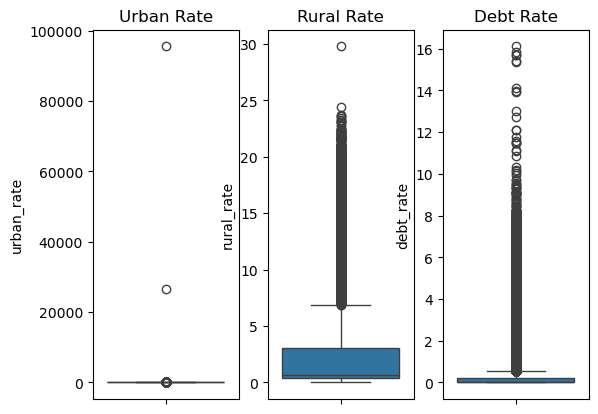

In [34]:
# identify the possibility of outliers visually with box / whisker plots

# Box plot for urban_rate
plt.subplot(1, 3, 1)
sns.boxplot(y=iowa_levy_rates_categorical_ready['urban_rate'])
plt.title('Urban Rate')

# Box plot for rural_rate
plt.subplot(1, 3, 2)
sns.boxplot(y=iowa_levy_rates_categorical_ready['rural_rate'])
plt.title('Rural Rate')

# Box plot for debt_rate
plt.subplot(1, 3, 3)
sns.boxplot(y=iowa_levy_rates_categorical_ready['debt_rate'])
plt.title('Debt Rate')

### Identifying and Removing Outliers Using Z-Score Method

After visually detecting potential outliers using boxplots, this step implements a statistical approach to remove extreme values from the dataset. The Z-score method is used to measure how many standard deviations each tax rate deviates from the mean. Any value with a Z-score greater than 3 or less than -3 is considered an outlier and removed from the dataset.

By applying this filter, we ensure that only typical values remain in the cleaned dataset while extreme outliers, which might be the result of data entry errors or significant tax anomalies, are excluded.

In [35]:
# Methodology for cleaning outliers = if z-score in any row is >3

# Calculate the z-score for each column manually
urban_z = (iowa_levy_rates_categorical_ready['urban_rate'] - iowa_levy_rates_categorical_ready['urban_rate'].mean()) / iowa_levy_rates_categorical_ready['urban_rate'].std()
rural_z = (iowa_levy_rates_categorical_ready['rural_rate'] - iowa_levy_rates_categorical_ready['rural_rate'].mean()) / iowa_levy_rates_categorical_ready['rural_rate'].std()
debt_z  = (iowa_levy_rates_categorical_ready['debt_rate']  - iowa_levy_rates_categorical_ready['debt_rate'].mean())  / iowa_levy_rates_categorical_ready['debt_rate'].std()

# Create a boolean mask: True if the absolute z-score for all columns is <= 3
mask = (urban_z.abs() <= 3) & (rural_z.abs() <= 3) & (debt_z.abs() <= 3)

iowa_levy_rates_clean = iowa_levy_rates_categorical_ready[mask].copy()
print("Original number of rows:", len(iowa_levy_rates_categorical_ready))
print("Number of rows after removing outliers:", len(iowa_levy_rates_clean))

Original number of rows: 85522
Number of rows after removing outliers: 81628


In [36]:
iowa_levy_rates_clean.describe()

,urban_rate,rural_rate,debt_rate
count,81628.000000,81628.000000,81628.000000
mean,3.726375,2.242711,0.369083
std,5.357281,3.737393,0.875963
min,0.000000,0.000000,0.000000
25%,0.432300,0.415180,0.000000
50%,0.637320,0.624965,0.000000
75%,7.480590,3.003372,0.000000
max,27.054520,15.864800,4.351830


### Trend Analysis of Average Urban, Rural, and Debt Tax Rates Over Fiscal Years

This visualization tracks the historical trends in urban, rural, and debt tax rates over multiple fiscal years, allowing us to analyze how property tax rates have evolved over time. By grouping the data by fiscal year and computing the mean tax rates, we can observe whether urban tax rates have been increasing more rapidly than rural rates or if debt tax rates have followed a unique trajectory.

Expected Insights
* Are tax rates rising, falling, or stable over time?
* Do urban and rural tax rates follow similar patterns?
* How volatile are debt tax rates compared to other categories?

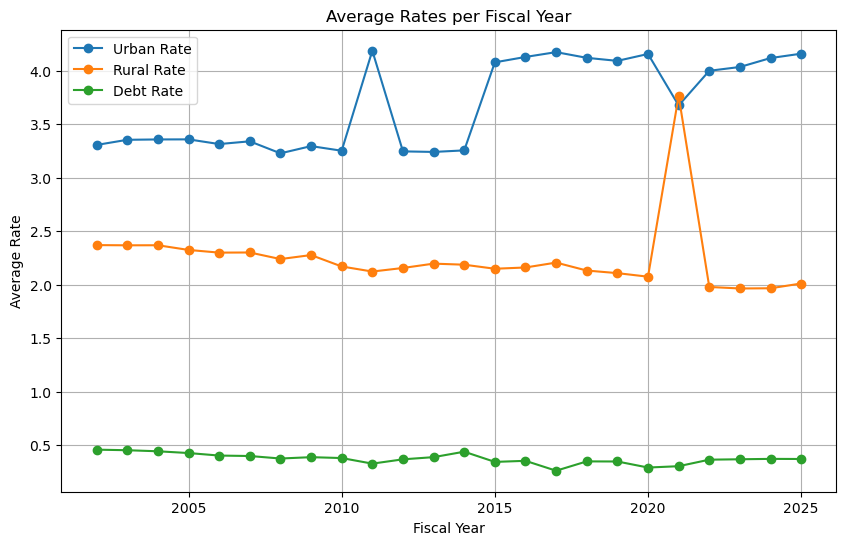

In [37]:
# Ensure the 'fiscal_year' column is treated as an integer (not a string)

iowa_levy_rates_clean['fiscal_year'] = iowa_levy_rates_clean['fiscal_year'].astype(int)

# Group data by fiscal year and calculate the mean values for urban_rate, rural_rate, and debt_rate
iowa_levy_rates_clean_grouped = iowa_levy_rates_clean.groupby('fiscal_year')[['urban_rate', 'rural_rate', 'debt_rate']].mean().reset_index()

# Create a new figure for the plot with a specified size
plt.figure(figsize=(10, 6))

# Plot the average urban, rural, and debt tax rate over fiscal years
plt.plot(iowa_levy_rates_clean_grouped['fiscal_year'], iowa_levy_rates_clean_grouped['urban_rate'], label='Urban Rate', marker='o')
plt.plot(iowa_levy_rates_clean_grouped['fiscal_year'], iowa_levy_rates_clean_grouped['rural_rate'], label='Rural Rate', marker='o')
plt.plot(iowa_levy_rates_clean_grouped['fiscal_year'], iowa_levy_rates_clean_grouped['debt_rate'],  label='Debt Rate',  marker='o')

plt.xlabel('Fiscal Year')
plt.ylabel('Average Rate')
plt.title('Average Rates per Fiscal Year')
plt.legend()
plt.grid(True)
plt.show()

### Kernel Density Estimation and Hisogram of the Distribution of Urban, Rural, and Debt Tax Rates

This visualization represents the distribution of urban, rural, and debt tax rates using histograms combined with Kernel Density Estimation (KDE). KDE is a smoothing technique that helps visualize the probability distribution of a dataset by creating a continuous density curve over the histogram. This allows us to better understand the underlying distribution of tax rates without the limitations of fixed histogram bin sizes, which can sometimes obscure patterns in the data.

We can determine whether most tax rates are concentrated around a central value or if significant variations exist. We can see a significant spike in the Rural Rate in 2021 as well as a sharp decline in the Urabn Rate in 2021--right when the pandemic began and when there was a large migration of people from urban to suburban/rural areas.

A big jump in rural rates for 2021 alongside a drop in urban rates suggests that local governments might have shifted their budget strategies in response to pandemic-related economic conditions. It could mean that county or township authorities, anticipating fewer taxable urban transactions or trying to offset lost revenue in other areas, raised rural levies to stabilize their budgets. Meanwhile, urban authorities may have reduced their rates in an attempt to stimulate local economies, encourage small business growth, or offer relief to property owners who were hit hard by shutdowns and capacity limits.

### Top 10 Counties with the Highest and Lowest Urban Tax Rates by Average

This analysis identifies the top 10 counties in Iowa with the highest and lowest average urban tax rates. By grouping the data by county and calculating the mean tax rates for urban, rural, and debt categories, we can determine which counties impose the heaviest and lightest tax burdens on urban properties.

In [38]:
iowa_levy_rates_clean['fiscal_year'] = iowa_levy_rates_clean['fiscal_year'].astype(int)

# Group by county and calculate mean rates
county_avg_rates = iowa_levy_rates_clean.groupby('county_name')[['urban_rate', 'rural_rate', 'debt_rate']].mean().reset_index()

# Sort counties by highest and lowest urban_rate
top_10_highest = county_avg_rates.sort_values(by='urban_rate', ascending=False).head(10)
top_10_lowest = county_avg_rates.sort_values(by='urban_rate', ascending=True).head(10)

# Display results
print("Top 10 Counties with Highest Urban Tax Rates:")
print(top_10_highest)

print("\nTop 10 Counties with Lowest Urban Tax Rates:")
print(top_10_lowest)


Top 10 Counties with Highest Urban Tax Rates:
   county_name  urban_rate  rural_rate  debt_rate
11      BUTLER    6.016599    3.524490   0.820486
13     CARROLL    5.213585    3.032335   0.520638
72        PAGE    5.197414    3.248484   0.401968
84       STORY    5.185963    3.034162   0.749399
32     FAYETTE    5.113589    2.805770   0.436820
98      WRIGHT    4.948567    2.788986   0.621605
22     CLINTON    4.861817    3.120658   0.509858
14        CASS    4.825355    2.711503   0.489839
70     O'BRIEN    4.818121    2.978833   0.496291
42    HARRISON    4.784260    2.697578   0.621201

Top 10 Counties with Lowest Urban Tax Rates:
   county_name  urban_rate  rural_rate  debt_rate
0        ADAIR    2.272349    1.304384   0.142092
47        IOWA    2.372709    1.816179   0.240604
7        BOONE    2.444409    1.227827   0.138099
5       BENTON    2.552948    1.035815   0.270119
1        ADAMS    2.574513    1.460698   0.155307
49      JASPER    2.630331    1.554766   0.256645
25      

In [39]:
iowa_levy_rates_clean['fiscal_year'] = iowa_levy_rates_clean['fiscal_year'].astype(int)

# Group by county and calculate mean rates
county_avg_rates = iowa_levy_rates_clean.groupby('county_name')[['urban_rate', 'rural_rate', 'debt_rate']].mean().reset_index()

# Sort counties by highest and lowest rural_rate
top_10_highest = county_avg_rates.sort_values(by='rural_rate', ascending=False).head(10)
top_10_lowest = county_avg_rates.sort_values(by='rural_rate', ascending=True).head(10)

# Display results
print("Top 10 Counties with Highest Rural Tax Rates:")
print(top_10_highest)

print("\nTop 10 Counties with Lowest Rural Tax Rates:")
print(top_10_lowest)


Top 10 Counties with Highest Rural Tax Rates:
   county_name  urban_rate  rural_rate  debt_rate
11      BUTLER    6.016599    3.524490   0.820486
95  WINNESHIEK    4.434568    3.420875   0.476771
72        PAGE    5.197414    3.248484   0.401968
43       HENRY    4.502072    3.207521   0.416573
22     CLINTON    4.861817    3.120658   0.509858
92       WAYNE    4.241129    3.061801   0.352815
84       STORY    5.185963    3.034162   0.749399
13     CARROLL    5.213585    3.032335   0.520638
35     FREMONT    4.327057    3.017612   0.424104
70     O'BRIEN    4.818121    2.978833   0.496291

Top 10 Counties with Lowest Rural Tax Rates:
   county_name  urban_rate  rural_rate  debt_rate
5       BENTON    2.552948    1.035815   0.270119
2    ALLAMAKEE    2.778561    1.137441   0.240289
7        BOONE    2.444409    1.227827   0.138099
0        ADAIR    2.272349    1.304384   0.142092
6   BLACK HAWK    3.241846    1.454806   0.331717
1        ADAMS    2.574513    1.460698   0.155307
60     M

### Urban Tax Rate Review

These counties sport urban rates in the 4.8–6.0 range. What’s interesting is that many of these are largely rural counties with small urban centers. In such places, urban property valuations might be on the lower side, which forces local governments to set higher tax rates to generate enough revenue.

Also, Urban Rates across counties are more distributed as opposed to Rural Rates - where rates might vary by +/- 1 for urban rates while rural rates change closer to roughly +/- .05 to .1.

In these counties, both urban and rural segments tend to have higher rates, potentially reflecting a fiscal environment where the tax base isn’t as deep. Essentially, if the properties aren’t valued very highly, the rate per $1,000 taxable value has to be bumped up to meet budget needs.

### Rural Tax Rate Review

A few counties show high rural rates (around 3.0–3.5). When you see both urban and rural rates on the higher end (as in Butler and Page), it often means that the overall taxable property values are relatively low in both areas, so the county needs to charge higher rates to cover its budget.

Lower rural rates may reflect a healthier economic balance in these areas, or simply that the counties have found a way to fund services without needing to burden rural property owners as heavily.

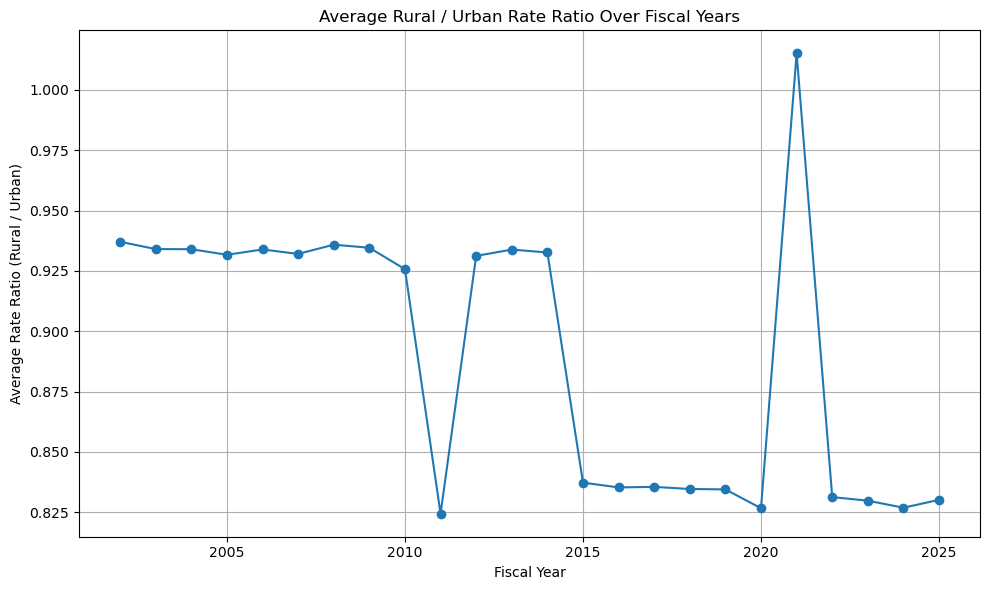

In [40]:
# Create a new column 'rate_ratio' that calculates urban_rate divided by rural_rate
iowa_levy_rates_clean['rate_ratio'] = iowa_levy_rates_clean['rural_rate'] / iowa_levy_rates_clean['urban_rate']

# Group the data by fiscal_year and calculate the mean rate_ratio for each year
avg_ratio_by_year = iowa_levy_rates_clean.groupby('fiscal_year')['rate_ratio'].mean().reset_index()

# Group the data by fiscal_year and calculate the mean rate_ratio for each year
avg_ratio_by_year = iowa_levy_rates_clean.groupby('fiscal_year')['rate_ratio'].mean().reset_index()

# Plot the average rate ratio over time
plt.figure(figsize=(10, 6))
plt.plot(avg_ratio_by_year['fiscal_year'], avg_ratio_by_year['rate_ratio'], marker='o', linestyle='-')
plt.title('Average Rural / Urban Rate Ratio Over Fiscal Years')
plt.xlabel('Fiscal Year')
plt.ylabel('Average Rate Ratio (Rural / Urban)')
plt.grid(True)
plt.tight_layout()
plt.show()

Review of Historical Rural / Ubran Rate Ratio

These two rates have varied over time, and in conjunction with each other. It's interesting to note that leadfing into the financial crisis, the ratio of rural / urban rates was relatively consistent, before swinging wildly and then seeming to settle much lower post 2015, with a big spike in 2021, likely caused by COVID. A further step in analysis would be to isolate this ratio by counties, to explore how mainly rural and mainly urban counties fared over time.

Run Linear Regression!

While there are two clear outputs in the rural and urban rates, it will be interesting to see how those variances over time can be explained by the time of year, the county debt rate, as well as how well the rural rate can predict variances in both the urban and rural rates

In [53]:
lr_model = LinearRegression()
lr_model.fit(X_train, y1_train)

# Calculate the r-squared metric for the regression
score = lr_model.score(X_test, y1_test)

# Print output
print('\nR-square = ', f'{score:.3f}')
print('Feature coefficients (aka slopes): \n')

for feature, coef in zip(X_train.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 

lr_model = LinearRegression()
lr_model.fit(X_train, y2_train)

# Calculate the r-squared metric for the regression
score = lr_model.score(X_test, y1_test)

# Print output
print('\nR-square = ', f'{score:.3f}')
print('Feature coefficients (aka slopes): \n')

for feature, coef in zip(X_train.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


R-square =  0.558
Feature coefficients (aka slopes): 

fiscal_year : -0.06
debt_rate : 2.33
county_fip : -0.02
tif_rate_rural : 0.46

R-square =  0.479
Feature coefficients (aka slopes): 

fiscal_year : 0.01
debt_rate : 0.24
county_fip : 0.00
tif_rate_rural : 1.12


# Conclusion

Consistency vs. Local Fluctuations: While tax rates are relatively stable statewide, each county’s local circumstances—services offered, debt levels, educational funding needs—create noticeable levy variations.

Historical Context Matters: Observed spikes in the rural/urban rate ratio during events like the housing crisis or the COVID era hint that external economic conditions do trickle down to local tax levies.

Some key questions we asked were:

1.    Are tax rates rising, falling, or stable over time?

  Overall, tax rates appear to be relatively stable across fiscal years, with only modest upward trends under normal conditions. However, during periods of economic stress—such as the onset of the pandemic in 2021—significant adjustments were made. In 2021, we see a marked spike in rural rates and a corresponding decline in urban rates. This divergence indicates that while the long-term trend is one of stability, local governments can and do make rapid, targeted adjustments in response to extraordinary fiscal pressures.


2.   Do urban and rural tax rates follow similar patterns?

  Not exactly. Urban tax rates across counties are more widely distributed, with differences of around ±1 point. This suggests that urban areas, which in many of these counties are actually small centers within predominantly rural environments, often have lower property valuations. In turn, higher rates are required to generate sufficient revenue. In contrast, rural tax rates show less variability—typically changing in a much tighter range (around +/- 0.05 to 0.1). The 2021 data underscore this divergence: as urban rates dipped (possibly to stimulate economic activity in hard-hit areas), rural rates spiked, perhaps reflecting an effort to compensate for a weaker tax base in those regions.


3. How volatile are debt tax rates compared to other categories?

  Debt tax rates, while generally lower in absolute value than urban or rural rates, tend to be less volatile. Their range is narrower, suggesting that they are more reflective of long-term fiscal obligations rather than rapid shifts in economic conditions. That said, in counties where overall taxable property values are low and fiscal pressures are high, even modest adjustments in debt rates can indicate significant budgetary stress. Thus, while debt tax rates are comparatively stable, they still serve as an important barometer of local fiscal health.



Further Targeted Analysis: Future work could involve drilling into specific counties that exhibit abnormal fluctuations, exploring how certain levy authorities (e.g., community colleges vs. K-12 schools) impact local rates, or evaluating how debt obligations influence the total consolidated levy mix.

We could tie in [Iowa Quarterly Retail Sales Tax Data by 12 Business Groups](https://data.iowa.gov/Taxes-Tax-Credits/Iowa-Quarterly-Retail-Sales-Tax-Data-by-12-Busines/wsde-3id9/about_data) again to explore how these tax rates interact with consumer behavior and business performance across counties. For example, in Homework 3, we found out the following:

"The year 2020 presented a stark contrast, marked by an incredible spike in taxable sales. This surge coincided with historically low mortgage rates—around 3% or less—and the onset of the COVID-19 pandemic. These compounding factors likely drove individuals to purchase homes and invest more in home furnishings as they adapted to lockdowns and remote living conditions. It would be intriguing to correlate this data with home sales figures in Jasper County during 2020 and compare it to the trends observed during the 2007-2008 market crash to gain deeper insights into consumer behavior during economic upheavals."

In addition, it seems that while the urban tif rate is perfectly correlated with urban tax rates, that is not true for rural tax rates. However, the rural tif rate explains over half the variance in the urban tax rate. It would be interesting to overlay specific urban vs. rural county data to understand if this is true across the state, as well as in other states.

When combing urban, rural and debt rates with the retail sales tax data, we can gain a richer, multi-dimensional picture of Iowa’s fiscal and economic landscape. This integrated view not only helps us understand how local governments balance their budgets under varying conditions but also highlights the direct impact of economic activity on tax policy, enabling homebuyers, policymakers and other stakeholders to better assess the fiscal health of counties in Iowa.
